---
# Cairo University Faculty of Engineering
## Machine Learning
## Assignment 3

---

Please write your full name here
- **Name** : "Mourad Magdy"

In [ ]:
%matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


np.random.seed(0)

### Part 1
Run the following cells to download fmnist dataset which will be used for the rest of the assignment.

In [ ]:
!pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm


In [ ]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute);
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

<ipython-input-3-00dc9b2e0d7e>:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  fmnist = oml.datasets.get_dataset(40996)


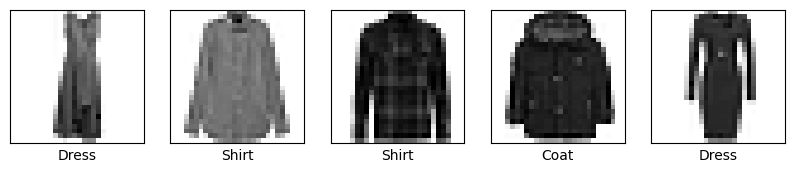

In [ ]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

### Question 1
First, we'll try the default Logistic Regression and k-Nearest Neighbors as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using cross_validation.

Implement the following `evaluate_learners` function which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You must use `cross_validate` function.

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1, random_state =0)

In [ ]:
def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data.

    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    ########## write your code here ##############
    train_scores,test_scores=[],[]
    for classifier in classifiers:
       cv=cross_validate(classifier,X,y,cv=5,return_train_score=True)
       train_score=cv['train_score']
       test_score=cv['test_score']
       train_scores.append(train_score)
       test_scores.append(test_score)
    return train_scores,test_scores


# # Example output:
# train_scores, test_scores = ([[0.92 , 0.924, 0.916, 0.917, 0.921],  # Classifier 1 train score for each of 5 folds.
#                               [0.963, 0.962, 0.953, 0.912, 0.934],  # Classifier 2 train score for each of 5 folds.
#                              [[0.801, 0.811, 0.806, 0.826, 0.804],  # Classifier 1 test score for each of 5 folds.
#                               [0.766, 0.756, 0.773, 0.756, 0.741],  # Classifier 2 test score for each of 5 folds.

With this small sample of our data we can now train and evaluate the two classifiers.

In [ ]:
classifiers = [LogisticRegression(), KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Print train scores and test scores.

In [ ]:
print(train_scores)
print(test_scores)

[array([0.9125    , 0.92053571, 0.92089286, 0.92089286, 0.91767857]), array([0.86375   , 0.86571429, 0.86321429, 0.86267857, 0.86821429])]
[array([0.835     , 0.80071429, 0.82      , 0.81428571, 0.81214286]), array([0.79428571, 0.82285714, 0.79857143, 0.81285714, 0.79928571])]


### Regularization
We will now tune these algorithm's main regularization hyperparameter: the regularization parameter in logistic regression (alpha), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for n_neighbors between 1 and 50. Alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Question 2
In the following cells we vary the regularization parameters in the range given above and, for each classifier, we create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, 2 plots are produced, one for each classifier. We use 5-fold cross validation for all scores, but only plot the means.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_c = {'C': np.logspace(-12, 12, num=22)}
param_k = {'n_neighbors': np.geomspace(1, 60, num=12, dtype=int)[1:]}
grids = [param_c, param_k]
grid_searches = [GridSearchCV(clf, grid, n_jobs=-1, cv=3, return_train_score=True).fit(Xs, ys) for clf,grid in zip(classifiers,grids)]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name, ax):
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp,bs,"  C:{:.2E}, ACC:{:.4f}".format(bp,bs))

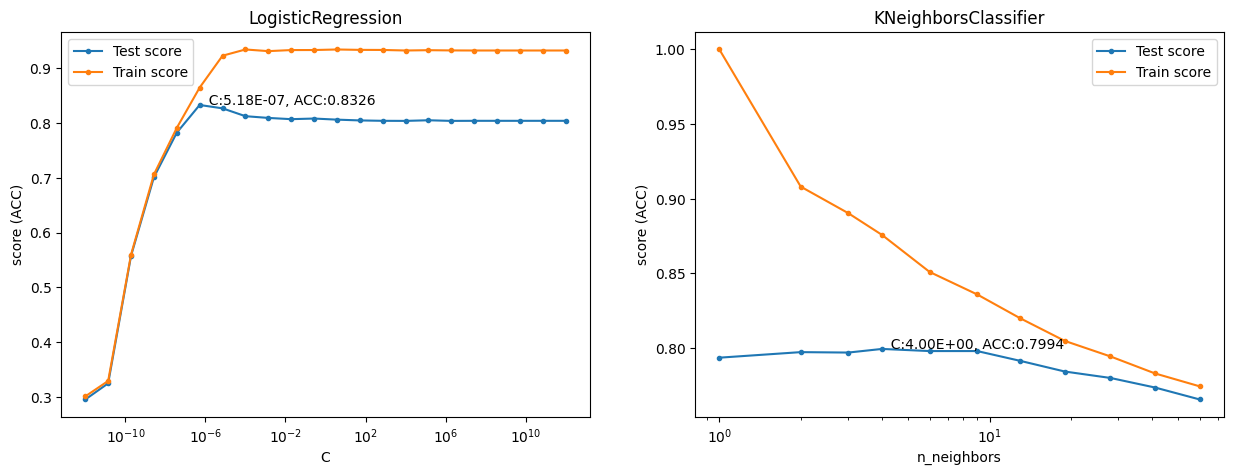

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches,['C','n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

- For logistic regression:underfitting when the hyperparameter (alpha) is 10e(-10), by increasing the value of  the hyperparameter, it began to perform well gradually.
It began to slightly overfit when it reached the value around 10e(-2) as there is a slight difference between the traingin and testing data scores. They are very sensitive to the regularization hyperparameter as we see that the scores changed much by increasing the hyperparameter to a certain limit

- For the KNeighbors: overfitting when the hyperparameter is 1 and it keeps decreasing by increasing the hyperparameter, the model's ability to generalize to unseen data isn't affected much by the hyperparameter, so the hyperparameter is affecting the overfitting of the training data not the ability of the model to generalize, it isn't underfitting.overfit dec. with large values of k

## Interpreting misclassifications
We train a logistic regression model on the data to look at the confusion matrix

In [ ]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

In [ ]:
# model implementation:
model = LogisticRegression(C=1e-7).fit(X_train,y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Question 3
A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results. Draw the complete confusion matrix for the true and predicted test data.

In [ ]:
#### Code for calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[147   2   2  12   0   0   9   0   3   0]
 [  0 169   4   2   0   0   0   0   0   0]
 [  2   0 119   1  32   0  18   0   3   0]
 [  8   0   1 155   5   0   6   0   0   0]
 [  0   0  16  10 135   0  14   0   0   0]
 [  0   0   0   0   0 122   0  34   1  18]
 [ 51   1  19   8  20   0  72   0   4   0]
 [  0   0   0   0   0   3   0 157   1  14]
 [  0   0   3   4   0   1   1   0 166   0]
 [  0   0   0   0   0   1   0  10   0 164]]


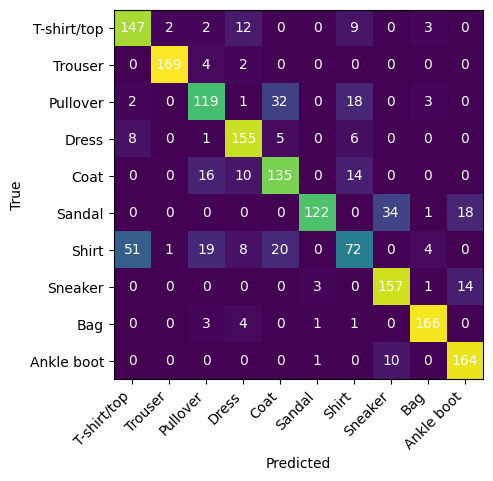

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

## Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Question 4
Train a Logistic Regression model using its tuned hyperparameter from gridsearch used above.
When in doubt, use `C=1e-7` for LogReg.
Pass the trained model to the provided plotting function. Interpret the results in detail.
Why do you get multiple plots per model? What do the features represent in your data.
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes?

In [ ]:
# Plots the coefficients of the given model as 28x28 heatmaps.
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

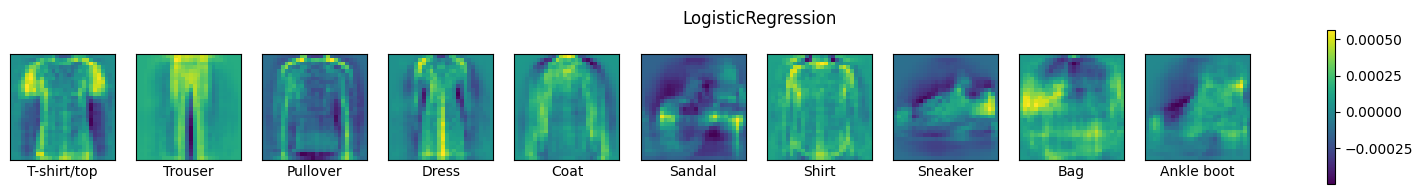

In [ ]:
##### Call on the function plot_coefficients using your trained model
plot_coefficients(model)


**Hint** that linear models are typically binary classifiers. They will solve multi-class problems in a one-vs-all approach. Hence, for a 10-class problem, they will build 10 models, each one trained to predict whether an instance is from a specific class or not. This leads to 10 sets of 784 trained coefficients. Above, we plot them as 28x28 matrices, such that each coefficient is plotted at the location of their corresponding pixel value.

**Answer:**
- why do you get multiple plots per model?
we get multiple plots because logistic regression when applied to a multi-class classification problems it solves it in a one vs all approach therefore they will build 10 models each one trained to predict whether an instance is from a specific class or not

- What do the features represent in your data?
it represents the pixel values in the image

- Does it seems like the models pay attention to the right features? Yes, there are pixels which are more bright than other pixels which means that they got higher weights, for example the first image represents a T-shirt, the model gave the pixels of  the t-shirt a more bright color than other pixels.

- Does your model seem to ignore certain features? Yes, it gives some pixels a dark color which means low weight.

- Do you observe differences in quality between the different classes? Yes, this may be due the fact that some classes like the T-shirt might have clear patters than other classes, might be also because some classes have similar appearnce so there might be overlapping features, might be imbalance in data during training.

### Question 5
Finally, out of curiosity, let's see the result of underfitting and overfitting on the learned coefficients:
Repeat the previous exercise, only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot.

In the cell below replace the ####### with your trained models with different alphas.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

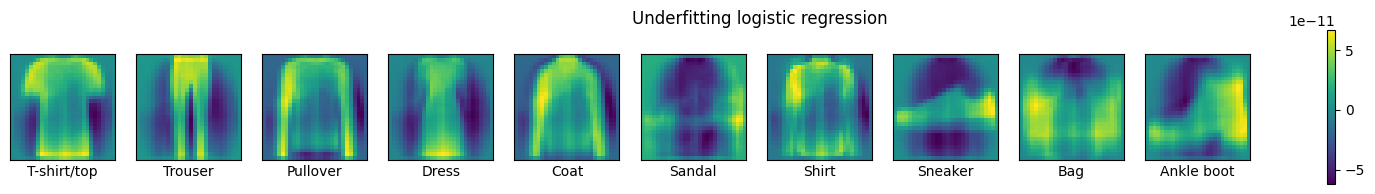

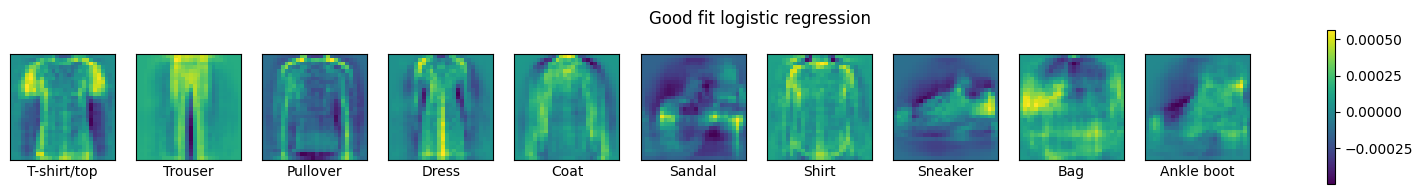

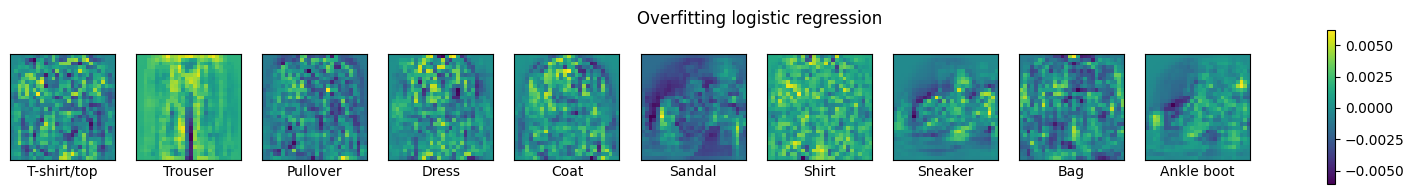

In [ ]:
underfitting_model=LogisticRegression(C=1e-15)
underfitting_model.fit(X_train,y_train)


good_model=LogisticRegression(C=1e-7)
good_model.fit(X_train,y_train)

overfitting_model=LogisticRegression(C=1e7)
overfitting_model.fit(X_train,y_train)


plot_coefficients(underfitting_model,"Underfitting logistic regression")
plot_coefficients(good_model,"Good fit logistic regression")
plot_coefficients(overfitting_model,"Overfitting logistic regression")

Interpret and explain the results.
* **Answer:**
- overfittig: Increasing the alpha much led to overfitting as the model was not able to give the proper weights to pixels so it appeared like this
- good fit: the model is able to give proper weights to the pixels

- underfit:the model isn't able to give proper weights to the features, for example the coat is similar to pullover, so it didn't learn to diffrenciate them well.

# Part 2

In this part, you will use a bank dataset that predicts customer response to telemarketing campaigns for term deposit.

You should follow the workflow we described in class to use logistic regression to train on the data

1. Train - Test split (80-20%)
    - Study and handle any imbalance in the data's target
2. Data Exploration and cleaning
    - Remove duplicates
    - Handle outliers
    - Handle missing values
    - Handle categorical data
    
    (dont forget to apply the same preprocessing to the test set!)
3. Model selection --> Select the best model:
    - Train an l2 regularized logistic regression model
        - Use crossvalidation with grid search to set the learning rate and the regularization hyperparameters
    - Train a logistic regression model without regullarization
        - Use crossvalidation with grid search to set the learning rate  hyperparameter
    - Don't forget normalization of features!
4. Test the chosen model on the test data
5. Interpret the results using confusion matrix --> how does it do on each class?

### Attribute information For bank dataset

### Input variables:
**Bank client data:**
*   1 - age : (numeric)
*   2 - job : type of job (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services")
*   3 - marital : marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed)
*   4 - education (categorical: "unknown", "secondary","primary", "tertiary")
*   5 - default: has credit in default? (binary: "yes", "no")
*   6 - balance: average yearly balance, in euros (numeric)
*   7 - housing: has housing loan? (binary: "yes", "no")
*   8 - loan: has personal loan? (binary: "yes", "no")
  
**Related with the last contact of the current campaign:**
*   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
*  10 - day: last contact day of the month (numeric)
*  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
*  12 - duration: last contact duration, in seconds (numeric)
   
**Other attributes:**
*  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
*  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
*  15 - previous: number of contacts performed before this campaign and for this client (numeric)
*  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

- The Output variable - y - describes whether the client has subscribed to a term deposit or not, ("yes" or "no")

# Load the dataset

In [ ]:
# load the data
import pandas as pd
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQu3jhgW0M1h44c7zV3y4Gl7V3gbM9rPSyMDvvJWKSzPB4nIzQ1UIVSBMMmHV647LjeA1SJOFCBdQl6/pub?gid=320855314&single=true&output=csv')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# Checking for Null Values

In [ ]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Drop duplicates

In [ ]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.shape

(45211, 17)

# There is a clear data imbalance in the dataset as the number of no is much more than yes, we will perform oversampling but after splitting the data

In [ ]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

# Splitting the data into 80% train and 20% test

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X=df.drop('y',axis=1)
y=df['y']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [ ]:
df_train.shape
# df_test.shape

(36168, 17)

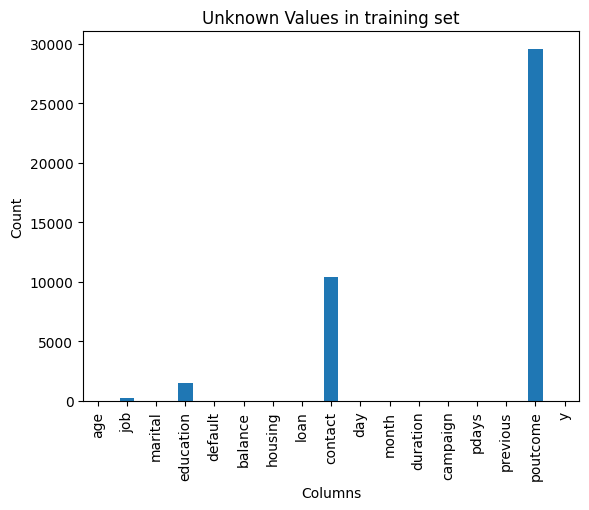

In [ ]:
import matplotlib.pyplot as plt
# Check for 'unknown' values in the training set
df_train_unknown_values = df_train.isin(['unknown']).sum()

# Plot the counts of 'unknown' values
df_train_unknown_values.plot(kind='bar')
plt.title("Unknown Values in training set")
plt.xlabel("Columns")
plt.ylabel("Count")
plt.show()


# From the above plot, it seems that the poutcome feature has alot of unknown values, as well as the contact and I think that contact feature is not very important in terms of my problem so, I will drop contact and poutcome.

# There is also some missing values in the education and job features so I will handle them by using the mode as they are categorical features to replace every unknown.

In [ ]:
df_train.drop('contact',axis=1,inplace=True)
df_train.drop('poutcome',axis=1,inplace=True)
df_test.drop('contact',axis=1,inplace=True)
df_test.drop('poutcome',axis=1,inplace=True)

df_train.head()


,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
32213,35,management,single,tertiary,no,1350,yes,no,16,apr,185,1,330,1,no
36907,59,admin.,married,secondary,no,145,yes,no,12,may,556,2,287,13,yes
1447,53,management,married,tertiary,no,1786,yes,no,8,may,66,2,-1,0,no
10973,37,management,married,tertiary,no,1170,no,yes,17,jun,153,3,-1,0,no
26982,46,entrepreneur,married,primary,no,829,no,yes,21,nov,81,7,-1,0,no


In [ ]:
from sklearn.impute import SimpleImputer
df_train.replace('unknown',np.nan,inplace=True)
df_test.replace('unknown',np.nan,inplace=True)
simple_imputer=SimpleImputer(strategy='most_frequent')
features_with_unknown_values=['education','job']

simple_imputer.fit(df_train[features_with_unknown_values])
df_train[features_with_unknown_values] = simple_imputer.transform(df_train[features_with_unknown_values])
df_test[features_with_unknown_values] = simple_imputer.transform(df_test[features_with_unknown_values])


# Boxplot of the training data to check for outliers

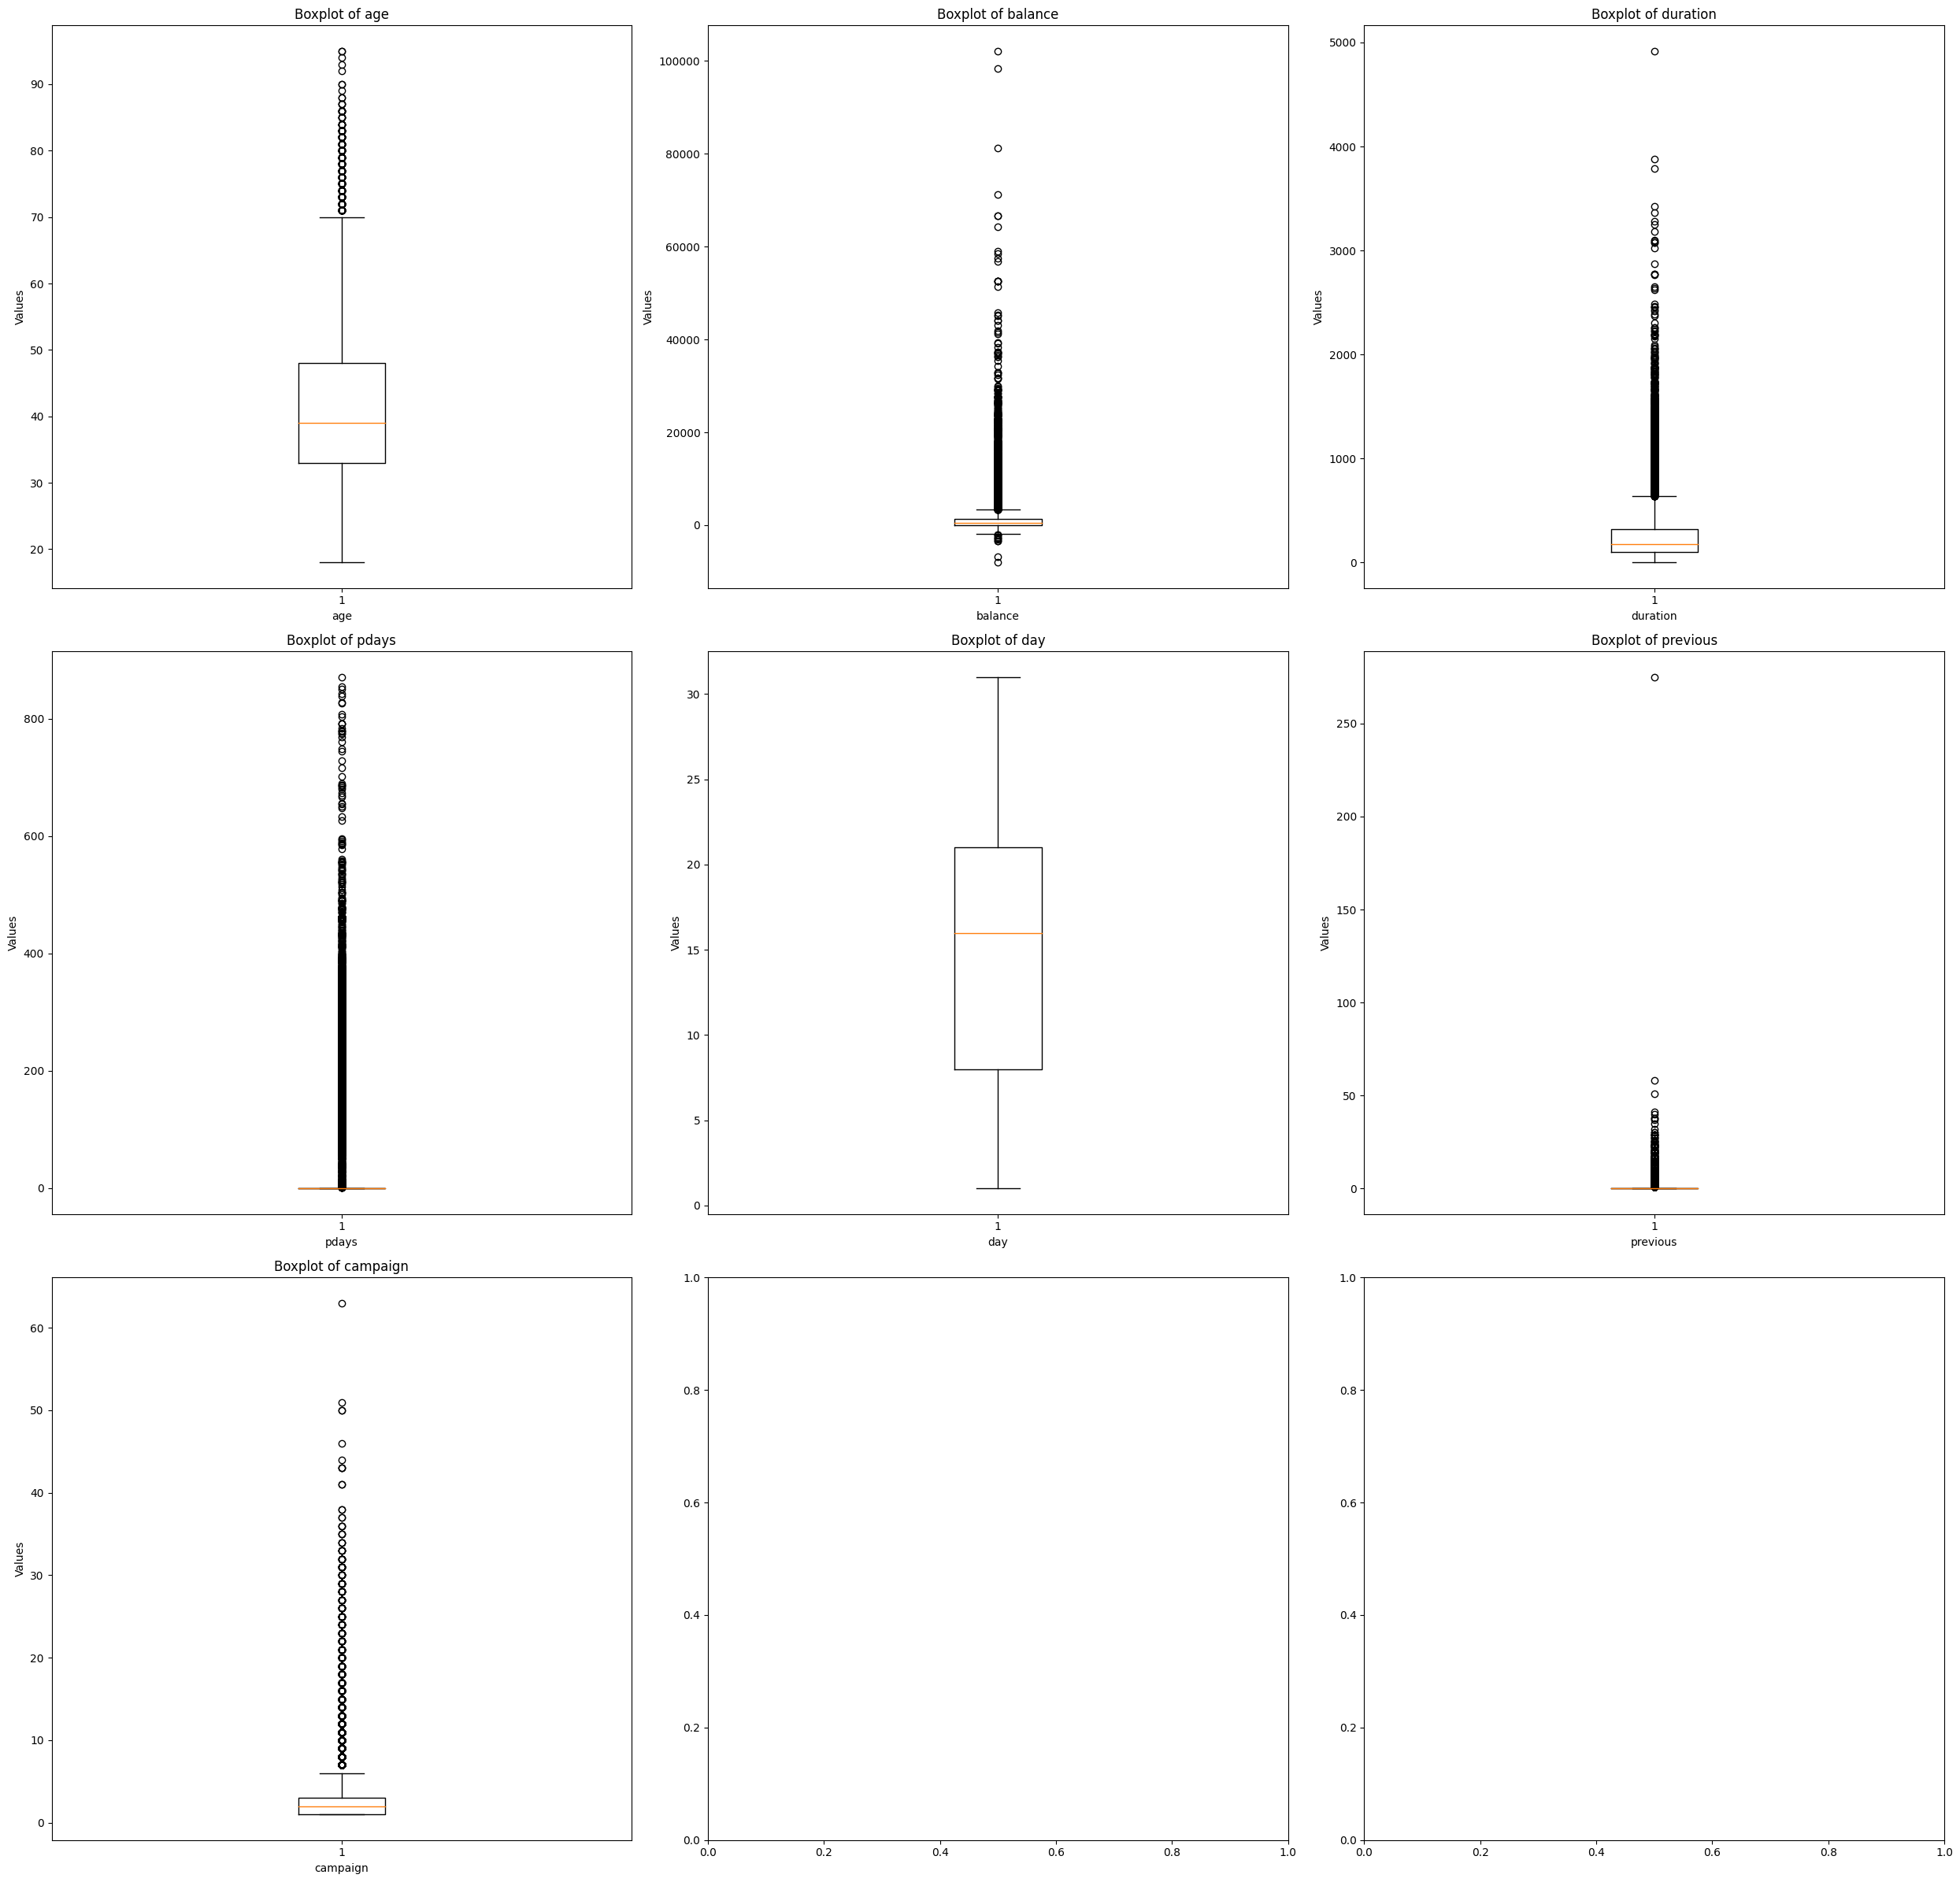

In [ ]:
numerical_features = ['age','balance','duration','pdays','day','previous','campaign']

def boxPlotting(data):
    num_features = len(numerical_features)
    num_rows = (num_features - 1) // 3 + 1
    fig, axes = plt.subplots(num_rows, 3, figsize=(25, 8 * num_rows))


    for i, feature in enumerate(numerical_features):

        ax = axes[i // 3, i % 3] if num_rows > 1 else axes[i % 3]
        ax.boxplot(data[feature])
        ax.set_xlabel(feature)
        ax.set_ylabel('Values')
        ax.set_title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()
boxPlotting(df_train)

# Removing the outliers using IQR method

In [ ]:
def remove_outliers(data,feature):
   q1=data[feature].quantile(0.25)
   q3=data[feature].quantile(0.75)
   iqr=q3-q1
   threshold=1.5*iqr

   lower=q1-threshold
   upper=q3+threshold

   filtered_data=data[(data[feature]>=lower)&(data[feature]<=upper)]
   return filtered_data
for index in numerical_features:
  df_train=remove_outliers(df_train,index)

# Boxplots after removal of outliers and we can seet that most of the outliers were removed

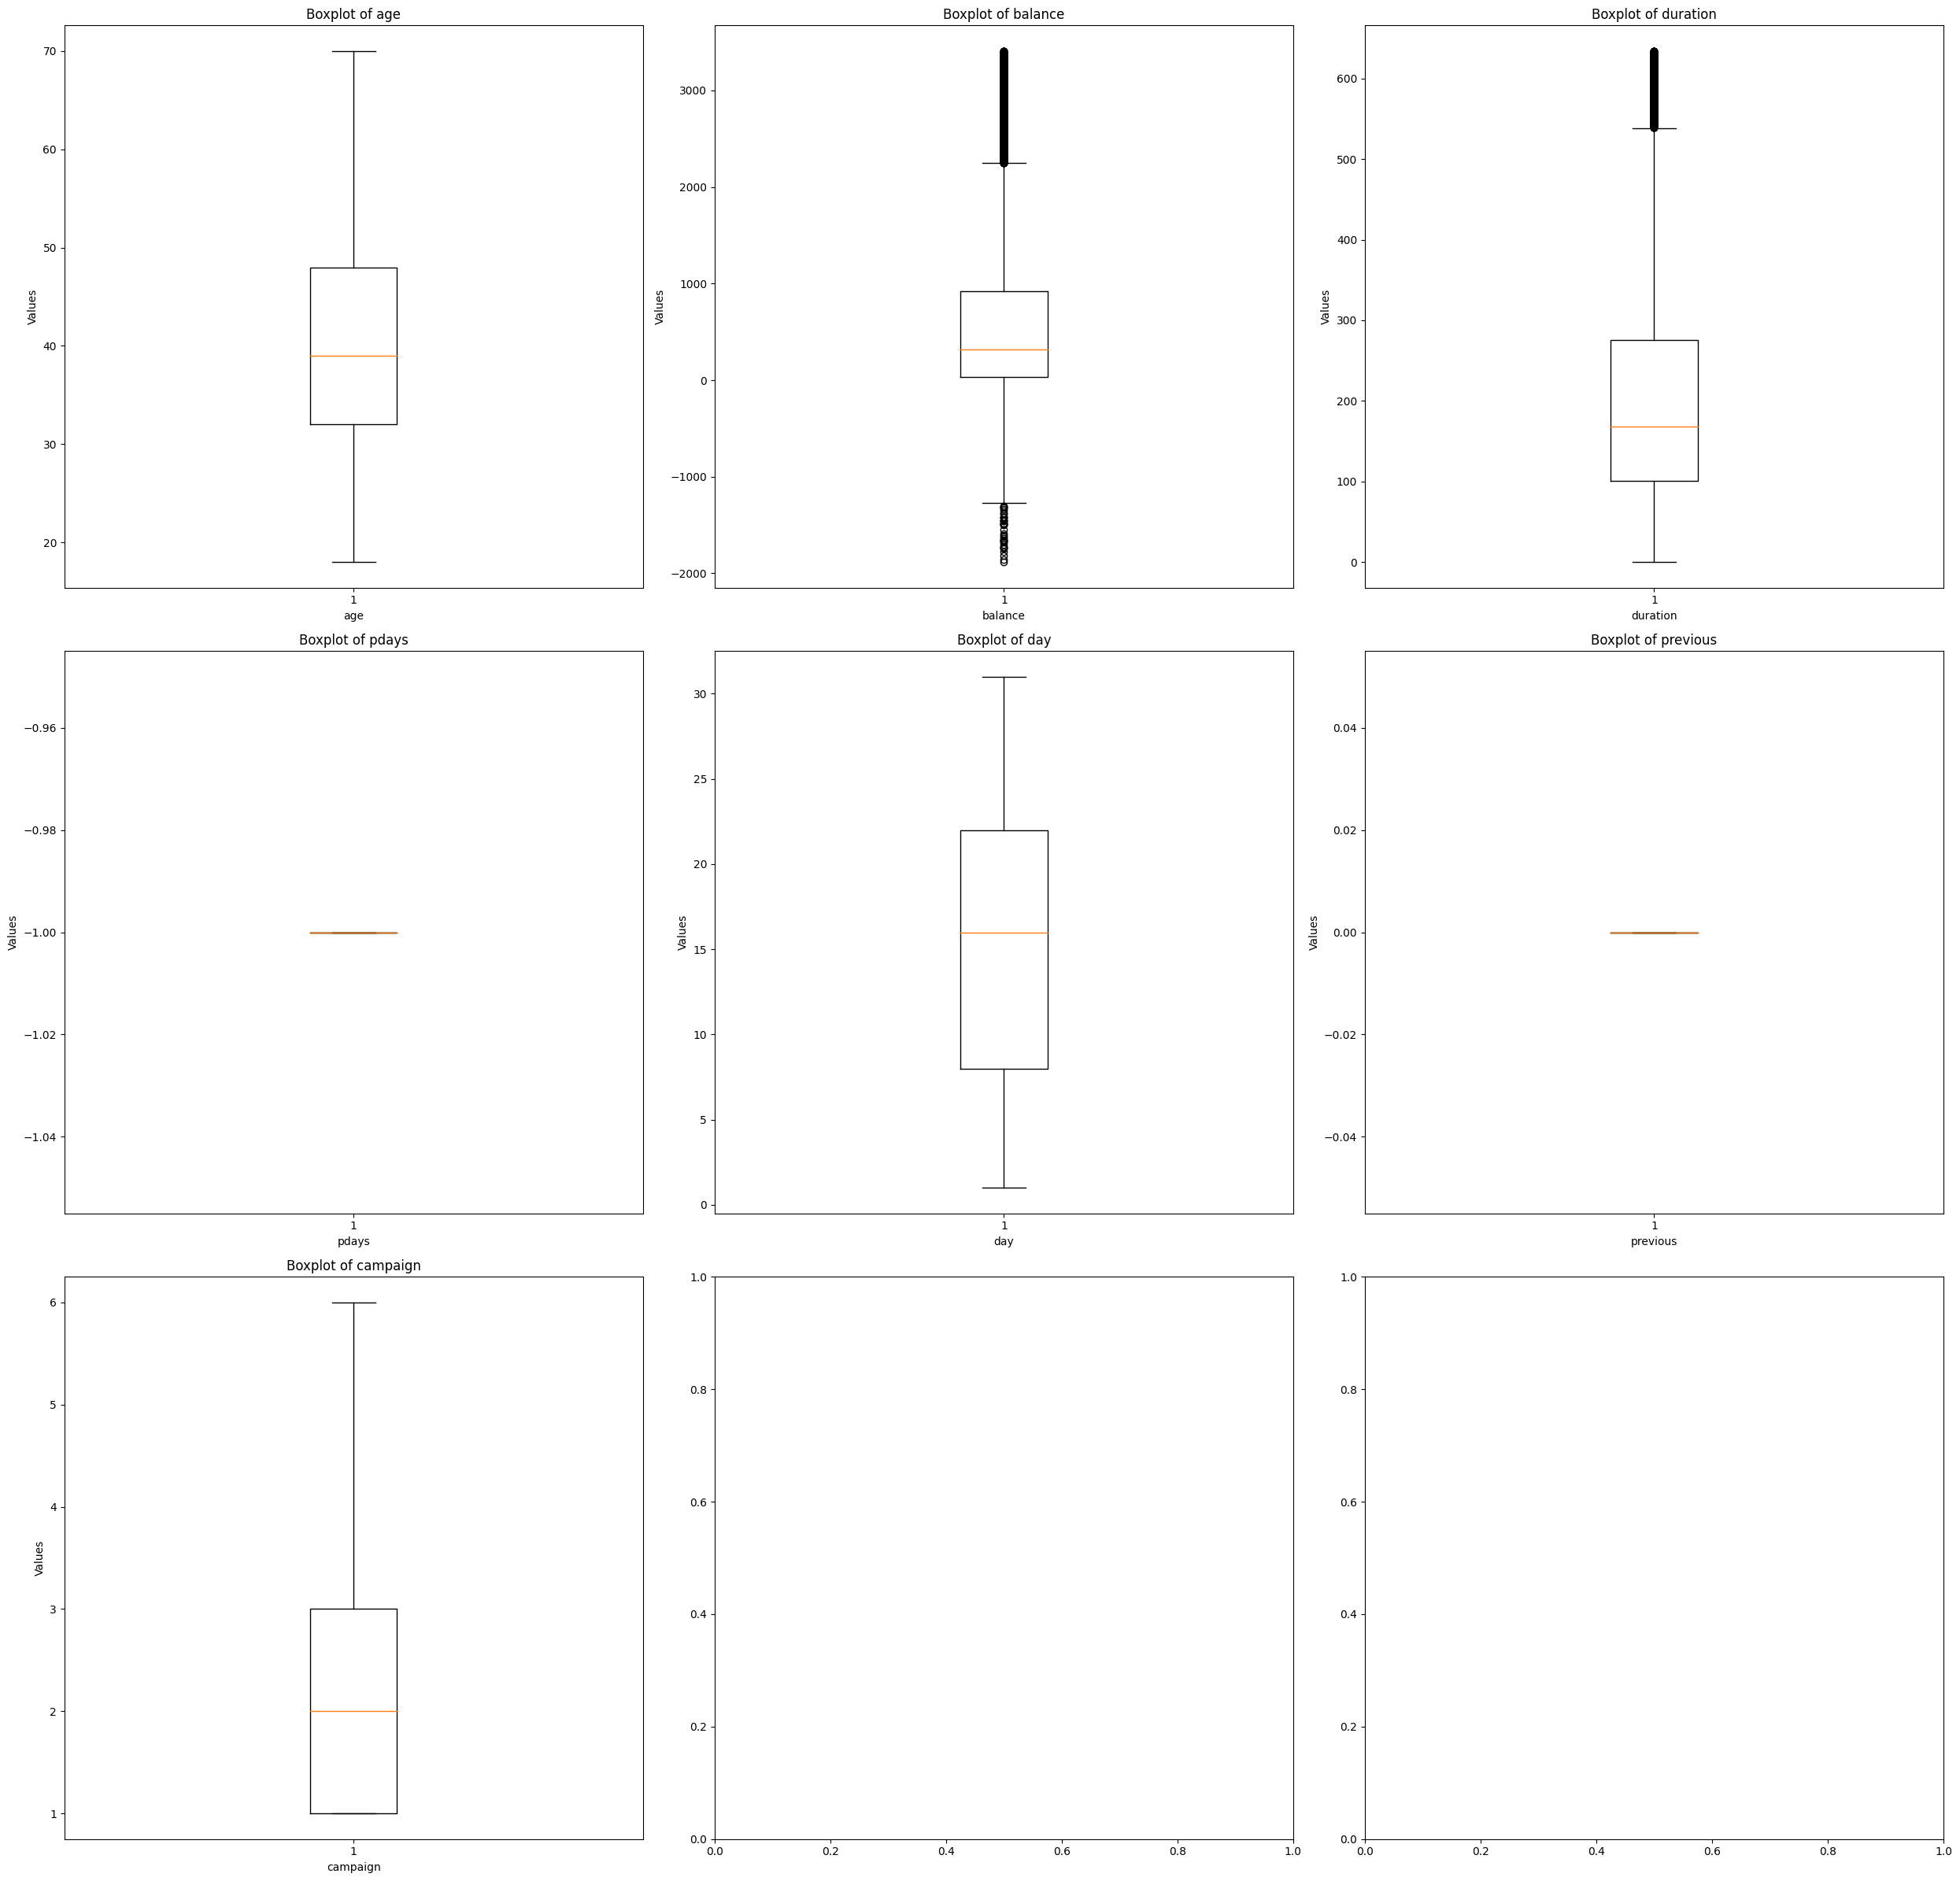

(22449, 15)

In [ ]:
boxPlotting(df_train)
df_train.shape

# One hot encoding to transform catergorical data into numerical

In [ ]:
X=df_train.drop('y',axis=1)
X=pd.get_dummies(X)
y=df_train['y']

x_hot_test=df_test.drop('y',axis=1)
y_host_test=df_test['y']


x_hot_test=pd.get_dummies(x_hot_test)
df_test = pd.concat([x_hot_test, y_host_test], axis=1)
df_test



,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
32936,34,551,17,115,2,315,11,0,1,0,...,0,0,0,0,0,0,0,0,0,no
1643,29,0,9,215,1,-1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,no
8565,31,0,3,31,5,-1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,no
7144,43,5172,29,57,3,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,no
32575,54,-133,17,76,1,343,2,0,0,0,...,0,0,0,0,0,0,0,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35507,31,799,7,556,3,-1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,no
2186,27,118,12,53,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,no
41085,46,336,14,260,3,457,1,0,1,0,...,0,0,0,0,0,0,0,0,0,yes
4735,31,897,20,26,2,-1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,no


# Oversampling due to the imbalance in the data

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_over_sample, y_over_sample = smote.fit_resample(X, y)
print(X_over_sample.shape)
print(y_over_sample.shape)
df_train = pd.DataFrame(X_over_sample, columns=X.columns)
df_train['y'] =y_over_sample

(42402, 42)
(42402,)


In [ ]:
df_train['y'] = df_train['y'].map({'yes': 1, 'no': 0})
df_test['y'] = df_test['y'].map({'yes': 1, 'no': 0})

df_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,53,1786,8,66,2,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,37,1170,17,153,3,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,58,-230,8,133,2,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,52,2102,18,292,2,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,43,0,8,123,2,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Standardizing the data

In [ ]:
# Standardizing
from sklearn.preprocessing import StandardScaler
normalize=StandardScaler()
df_train_scaled=normalize.fit_transform(df_train)
df_test_scaled=normalize.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, columns=df_test.columns)
df_train=df_train_scaled
df_test=df_test_scaled

df_train

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,1.338154,1.249161,-0.881213,-1.260147,0.091673,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,2.096180,-0.197445,-0.080202,-0.061737,-1.0
1,-0.238475,0.536085,0.251867,-0.718851,0.930860,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,3.439426,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,-1.0
2,1.830850,-1.084542,-0.881213,-0.843287,0.091673,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,2.983686,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,-1.0
3,1.239614,1.614959,0.377765,0.145980,0.091673,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,2.983686,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,-1.0
4,0.352761,-0.818297,-0.881213,-0.905505,0.091673,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,2.096180,-0.197445,-0.080202,-0.061737,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42397,-0.435553,0.931981,0.000071,0.009100,-0.747514,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,1.0
42398,-0.238475,0.370549,-0.503520,0.046431,-0.747514,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,1.0
42399,0.451300,2.484310,0.125969,-0.563305,-0.747514,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,1.0
42400,-0.632632,-0.190882,-0.629418,-0.264659,-0.747514,0.0,0.0,-0.2708,-0.385214,-0.136088,...,-0.177844,-0.123597,-0.335156,-0.290746,-0.088294,-0.477058,-0.197445,-0.080202,-0.061737,1.0


In [ ]:
X_train=df_train.drop('y',axis=1)
y_train=df_train['y']

X_test=df_test.drop('y',axis=1)
y_test=df_test['y']

# Train an l2 regularized logistic regression model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_c = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "logreg__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(penalty='l2'))])

gs = GridSearchCV(pipe,param_grid=param_c,refit=True,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print("train score: ", gs.score(X_train, y_train)*100)
print("test score: ", gs.score(X_test, y_test)*100)


Best Accuracy: 96.54%
Best Params: {'logreg__C': 100, 'logreg__solver': 'newton-cg'}
train score:  97.04495070987218
test score:  88.65420767444432


In [ ]:
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 88.65%


# Confusion matrix

[[7608  377]
 [ 649  409]]
              precision    recall  f1-score   support

        -1.0       0.92      0.95      0.94      7985
         1.0       0.52      0.39      0.44      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.67      0.69      9043
weighted avg       0.87      0.89      0.88      9043



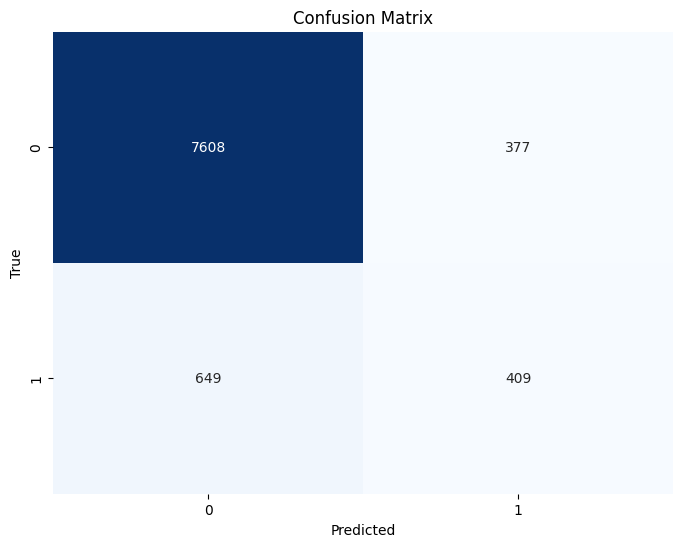

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Get predictions
y_pred = gs.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
report = classification_report(y_test, y_pred)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Train an l2 non regularized logistic regression model

In [ ]:
param_c={"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs=GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=param_c, refit=True,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print("train score: ",gs.score(X_train,y_train)*100)
print("test score: ",gs.score(X_test,y_test)*100)

Best Accuracy: 96.51%
Best Params: {'solver': 'lbfgs'}
train score:  97.03787557190698
test score:  88.60997456596263


In [ ]:
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 88.61%


# Confusion matrix

[[7602  383]
 [ 647  411]]
              precision    recall  f1-score   support

        -1.0       0.92      0.95      0.94      7985
         1.0       0.52      0.39      0.44      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.67      0.69      9043
weighted avg       0.87      0.89      0.88      9043



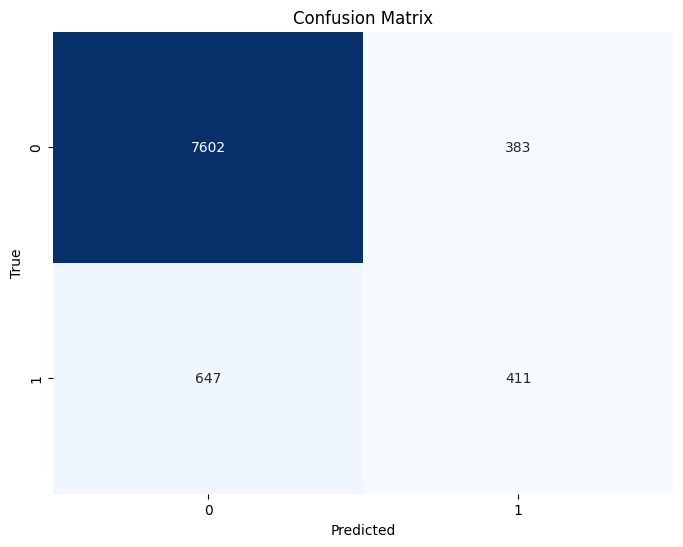

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = gs.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
report = classification_report(y_test, y_pred)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- The number of true positives and true negatives is high, therefore the models performs well , it performs well on the negative class and weaker on the positive class.